In [1]:
import numpy as np
import pandas as pd
import optuna
import sklearn.ensemble
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import shap
shap.initjs()

from src.dataloader import read_xlsx

c:\Users\simon\anaconda3\envs\PPA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading & exploration

In [2]:
soc_dem, products, in_out, sales = read_xlsx("./data/Task_Data_Scientist_Dataset.xlsx")

In [3]:
soc_dem.isna().sum()
soc_dem = soc_dem.fillna("X")

In [4]:
products = products.fillna(0)
products.head()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.000000,0.0,0.000000,0.0
1,2,1,1.0,0.0,0.0,0.0,0.0,110.768571,13326.190357,0.000000,0.0,0.000000,0.0
2,3,1,0.0,1.0,0.0,0.0,0.0,482.654643,0.000000,107.251786,0.0,0.000000,0.0
3,4,1,1.0,0.0,0.0,1.0,0.0,1599.840714,76.437143,0.000000,0.0,1110.381786,0.0
4,5,1,1.0,0.0,0.0,0.0,0.0,5353.483929,8079.715714,0.000000,0.0,0.000000,0.0


In [5]:
in_out.head()

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1,1678.946429,1318.698214,25,23,1891.353214,1335.619643,250.000000,283.089286,247.607143,50,30,3,12,9
1,2,708.129643,704.935714,4,3,386.442857,386.442857,307.142857,38.407143,35.714286,6,6,2,2,1
2,3,1607.149643,1607.149643,4,4,123.750000,123.750000,0.000000,112.857143,10.678571,3,3,0,1,1
3,4,1872.483571,1822.589643,9,4,3614.747500,3598.950357,714.285714,526.037500,1963.165357,41,36,6,12,13
4,5,4372.773929,2964.290357,23,14,5868.460714,4031.925000,157.142857,832.175000,1779.571429,44,41,4,17,13


In [6]:
in_out.isna().sum()

Client                          0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
TransactionsDeb                 0
TransactionsDeb_CA              0
TransactionsDebCash_Card        0
TransactionsDebCashless_Card    0
TransactionsDeb_PaymentOrder    0
dtype: int64

In [7]:
sales.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,1,0,0,26.972679,0.0,0.0
1,2,0,0,0,0.000000,0.0,0.0
2,6,0,0,0,0.000000,0.0,0.0
3,8,0,0,0,0.000000,0.0,0.0
4,13,0,0,0,0.000000,0.0,0.0


In [8]:
sales.isna().sum()

Client        0
Sale_MF       0
Sale_CC       0
Sale_CL       0
Revenue_MF    0
Revenue_CC    0
Revenue_CL    0
dtype: int64

In [9]:
soc_dem

,Client,Sex,Age,Tenure
0,1,F,51,7
1,2,M,43,152
2,3,M,17,140
3,4,M,24,153
4,5,F,58,200
...,...,...,...,...
1610,1611,F,41,181
1611,1612,M,63,114
1612,1613,M,46,45
1613,1614,M,48,65


In [10]:
products

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.000000,0.0,0.000000,0.0
1,2,1,1.0,0.0,0.0,0.0,0.0,110.768571,13326.190357,0.000000,0.0,0.000000,0.0
2,3,1,0.0,1.0,0.0,0.0,0.0,482.654643,0.000000,107.251786,0.0,0.000000,0.0
3,4,1,1.0,0.0,0.0,1.0,0.0,1599.840714,76.437143,0.000000,0.0,1110.381786,0.0
4,5,1,1.0,0.0,0.0,0.0,0.0,5353.483929,8079.715714,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,1611,1,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1611,1612,1,0.0,0.0,1.0,0.0,1.0,170.593214,0.000000,0.000000,0.0,0.000000,6250.0
1612,1613,1,0.0,0.0,0.0,0.0,0.0,676.008571,0.000000,0.000000,0.0,0.000000,0.0
1613,1614,1,0.0,0.0,0.0,0.0,0.0,0.010357,0.000000,0.000000,0.0,0.000000,0.0


In [11]:
basetable = soc_dem.merge(products, on=["Client"], how="left")\
    .merge(in_out, on=["Client"], how="left")\
    .merge(sales, on=["Client"], how="left")

In [12]:
basetable

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,F,51,7,1,0.0,0.0,1.0,0.0,0.0,...,30.0,3.0,12.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
1,2,M,43,152,1,1.0,0.0,0.0,0.0,0.0,...,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,3,M,17,140,1,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,M,24,153,1,1.0,0.0,0.0,1.0,0.0,...,36.0,6.0,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,F,58,200,1,1.0,0.0,0.0,0.0,0.0,...,41.0,4.0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,1611,F,41,181,1,0.0,0.0,1.0,0.0,0.0,...,11.0,1.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1611,1612,M,63,114,1,0.0,0.0,1.0,0.0,1.0,...,9.0,2.0,0.0,2.0,0.0,0.0,0.0,0.000000,0.0,0.0
1612,1613,M,46,45,1,0.0,0.0,0.0,0.0,0.0,...,25.0,2.0,12.0,8.0,1.0,0.0,0.0,2.088571,0.0,0.0
1613,1614,M,48,65,1,0.0,0.0,0.0,0.0,0.0,...,15.0,1.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Correlation Matrix')

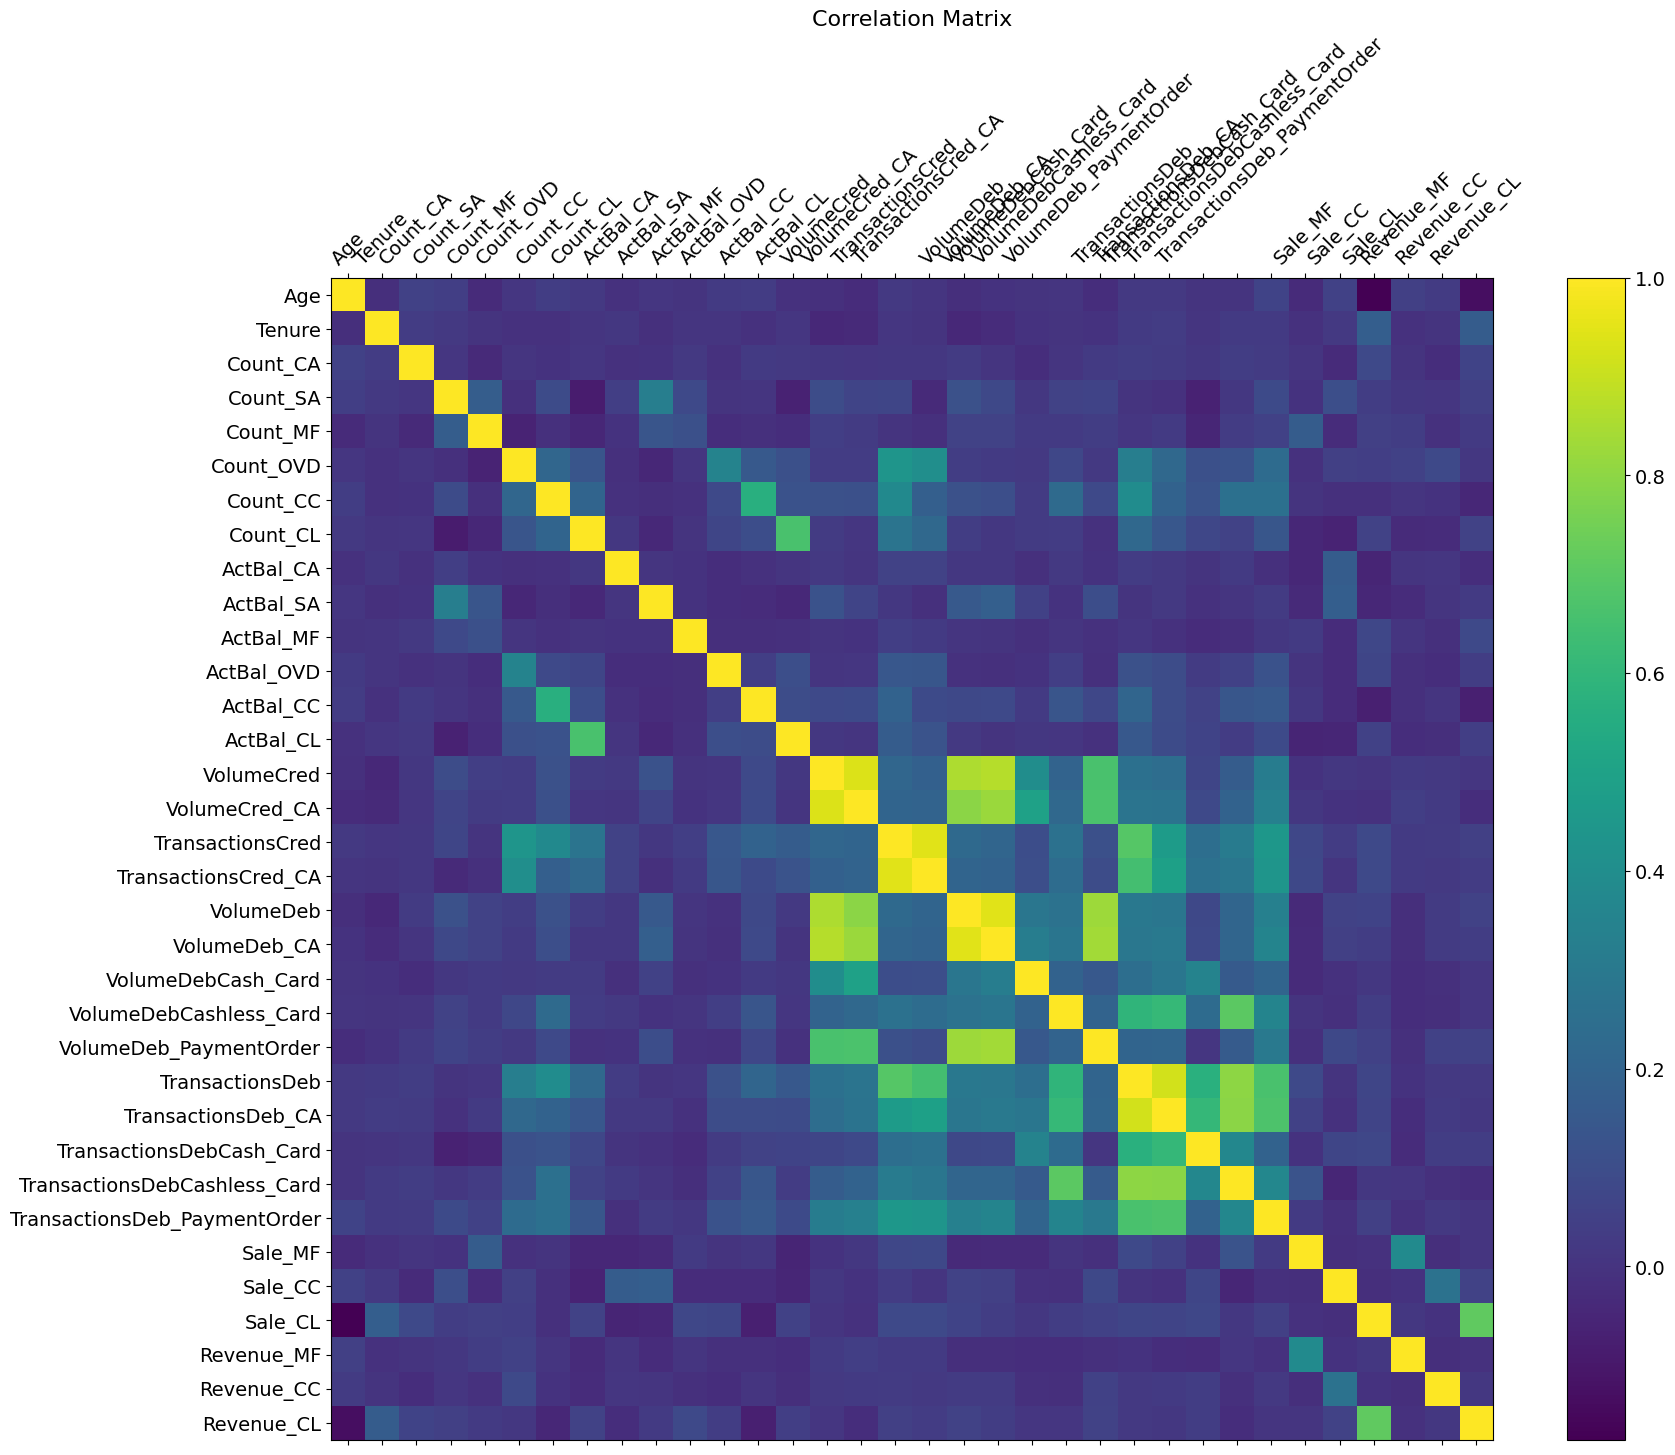

In [13]:

f = plt.figure(figsize=(19, 15))
plt.matshow(basetable.drop(["Sex", "Client"], axis=1).corr(), fignum=f.number)
plt.xticks(range(basetable.drop(["Sex", "Client"], axis=1).shape[1]), basetable.drop(["Sex", "Client"], axis=1).columns, fontsize=14, rotation=45)
plt.yticks(range(basetable.drop(["Sex", "Client"], axis=1).shape[1]), basetable.drop(["Sex", "Client"], axis=1).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)


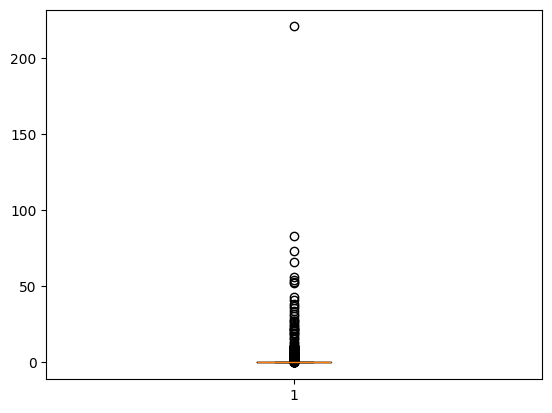

In [15]:
plt.boxplot(basetable.Revenue_MF.dropna())
plt.show()

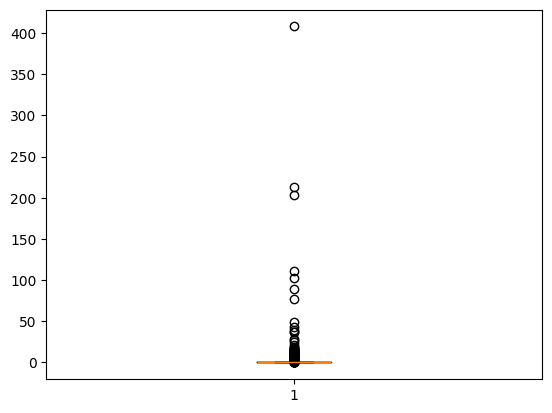

In [16]:
plt.boxplot(basetable.Revenue_CC.dropna())
plt.show()

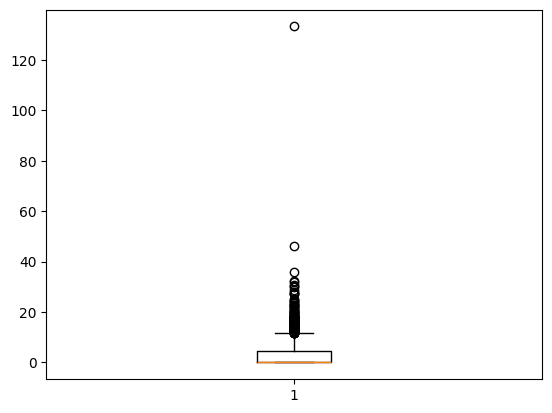

In [17]:
plt.boxplot(basetable.Revenue_CL.dropna())
plt.show()

These outliers can be hard to detect, but have a large impact on the total revenue

### Create train/test split
test = where sales are NaN, for deployment


In [18]:
train = basetable.loc[-basetable.Sale_MF.isna()]
test = basetable.loc[basetable.Sale_MF.isna()].drop(["Sale_MF", "Sale_CC", "Sale_CL", "Revenue_MF", "Revenue_CC", "Revenue_CL"], axis=1)

In [19]:
train

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,F,51,7,1,0.0,0.0,1.0,0.0,0.0,...,30.0,3.0,12.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
1,2,M,43,152,1,1.0,0.0,0.0,0.0,0.0,...,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,6,F,24,19,1,0.0,0.0,0.0,0.0,1.0,...,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,8,F,64,30,1,0.0,0.0,1.0,0.0,0.0,...,24.0,10.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
12,13,F,66,132,1,1.0,0.0,0.0,0.0,1.0,...,39.0,6.0,17.0,10.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,1607,M,38,21,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1607,1608,F,63,108,1,0.0,0.0,0.0,1.0,1.0,...,23.0,2.0,10.0,4.0,0.0,0.0,0.0,0.000000,0.0,0.0
1611,1612,M,63,114,1,0.0,0.0,1.0,0.0,1.0,...,9.0,2.0,0.0,2.0,0.0,0.0,0.0,0.000000,0.0,0.0
1612,1613,M,46,45,1,0.0,0.0,0.0,0.0,0.0,...,25.0,2.0,12.0,8.0,1.0,0.0,0.0,2.088571,0.0,0.0


After merging NA values are introduced. These can be safely set at 0.

In [20]:
train.isna().sum()

Client                           0
Sex                              0
Age                              0
Tenure                           0
Count_CA                         0
Count_SA                         0
Count_MF                         0
Count_OVD                        0
Count_CC                         0
Count_CL                         0
ActBal_CA                        0
ActBal_SA                        0
ActBal_MF                        0
ActBal_OVD                       0
ActBal_CC                        0
ActBal_CL                        0
VolumeCred                      18
VolumeCred_CA                   18
TransactionsCred                18
TransactionsCred_CA             18
VolumeDeb                       18
VolumeDeb_CA                    18
VolumeDebCash_Card              18
VolumeDebCashless_Card          18
VolumeDeb_PaymentOrder          18
TransactionsDeb                 18
TransactionsDeb_CA              18
TransactionsDebCash_Card        18
TransactionsDebCashl

In [21]:
# Impute missing values
train = train.fillna(0)
test = test.fillna(0)

## Modeling

In [22]:
# Seperate independent and dependent var
X_sales = train.iloc[:,1:30]
MF_sales = train.Sale_MF
CC_sales = train.Sale_CC
CL_sales = train.Sale_CL
MF_revenue = train.Revenue_MF
CC_revenue = train.Revenue_CC
CL_revenue = train.Revenue_CL

In [23]:
# Revenues not needed in this predictive model
train_sales = train.drop(["Revenue_MF", "Revenue_CC", "Revenue_CL"], axis=1)

In [56]:
# Train-test split
X_train, X_test, MF_train, MF_test, CC_train, CC_test, CL_train, CL_test, MF_train_rev, MF_test_rev, CC_train_rev, CC_test_rev, CL_train_rev, CL_test_rev = train_test_split(X_sales, MF_sales, CC_sales, CL_sales, MF_revenue, CC_revenue, CL_revenue, test_size=0.2, random_state=42)

In [57]:
# Preprocessing pipeline
numeric_features = [*range(1,29)]
categorical_features = [0]
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder(drop='first'))
Preprocessor = ColumnTransformer(transformers=[("numeric_transformer", numeric_transformer, numeric_features), ("categorical_transformer", categorical_transformer, categorical_features)])

In [58]:
# Preprocess and extract feature names
X_train_prep = Preprocessor.fit(X_train).transform(X_train)
names_after = Preprocessor.get_feature_names_out()
names_after = np.array([s.split("__")[1] for s in names_after])

### Baseline Linear Model: Lasso

In [59]:
# Lasso regression using 5-fold CV on 1000 penalty values
Classifier = sklearn.linear_model.LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear')
pipeline_LR = make_pipeline(Preprocessor, Classifier)

In [60]:
pipeline_LR.fit(X_train, MF_train)
# Predictions training set
MF_pred_LR = pipeline_LR.predict(X=X_test)
print("MF test balanced accuracy: ", sklearn.metrics.balanced_accuracy_score(y_pred=MF_pred_LR, y_true=MF_test))

pipeline_LR.fit(X_train, CC_train)
# Predictions training set
CC_pred_LR = pipeline_LR.predict(X=X_test)
print("CC test balanced accuracy: ", sklearn.metrics.balanced_accuracy_score(y_pred=CC_pred_LR, y_true=CC_test))

pipeline_LR.fit(X_train, CL_train)
# Predictions training set
CL_pred_LR = pipeline_LR.predict(X=X_test)
print("CL test balanced accuracy: ", sklearn.metrics.balanced_accuracy_score(y_pred=CL_pred_LR, y_true=CL_test))

MF test balanced accuracy:  0.5092532467532468
CC test balanced accuracy:  0.5541871921182266
CL test balanced accuracy:  0.635978835978836


### Random Forest

In [32]:
# Define Optuna objective 
def objective(trial, X_train, y_train):

    max_features = trial.suggest_int('max_features', 4, 30)
    min_samples_split = trial.suggest_float('min_samples_split', 0.0, 1.0)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 40)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    
    Classifier = sklearn.ensemble.RandomForestClassifier(
        max_features= max_features,
        max_depth= max_depth,
        min_samples_leaf = min_samples_leaf,
        min_samples_split= min_samples_split,
        n_estimators = n_estimators,
        random_state=42
    )

    pipeline = make_pipeline(Preprocessor, Classifier)

    score = sklearn.model_selection.cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='balanced_accuracy').mean()
    return score

def perform_study(X_train, y_train, n_trials=100):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=n_trials)
    print(study.best_trial)
    return(study)


In [33]:
# Perform Optuna study
study_MF = perform_study(X_train=X_train, y_train=MF_train, n_trials=300)
study_CL = perform_study(X_train=X_train, y_train=CL_train, n_trials=300)
study_CC = perform_study(X_train=X_train, y_train=CC_train, n_trials=300)

[I 2024-07-19 19:39:00,108] A new study created in memory with name: no-name-76221ae3-5708-44cd-821a-5b3188b91801
[I 2024-07-19 19:39:04,695] Trial 0 finished with value: 0.5 and parameters: {'max_features': 27, 'min_samples_split': 0.5424298215213149, 'max_depth': 18, 'min_samples_leaf': 26, 'n_estimators': 181}. Best is trial 0 with value: 0.5.
[I 2024-07-19 19:39:07,871] Trial 1 finished with value: 0.5 and parameters: {'max_features': 25, 'min_samples_split': 0.5250573075806239, 'max_depth': 8, 'min_samples_leaf': 20, 'n_estimators': 183}. Best is trial 0 with value: 0.5.
[I 2024-07-19 19:39:09,964] Trial 2 finished with value: 0.5 and parameters: {'max_features': 21, 'min_samples_split': 0.5382635334926273, 'max_depth': 12, 'min_samples_leaf': 39, 'n_estimators': 68}. Best is trial 0 with value: 0.5.
[I 2024-07-19 19:39:10,069] Trial 3 finished with value: 0.5 and parameters: {'max_features': 11, 'min_samples_split': 0.5824907210057344, 'max_depth': 16, 'min_samples_leaf': 22, 'n_

FrozenTrial(number=221, state=1, values=[0.5531354838709677], datetime_start=datetime.datetime(2024, 7, 19, 19, 41, 54, 860021), datetime_complete=datetime.datetime(2024, 7, 19, 19, 41, 54, 991835), params={'max_features': 18, 'min_samples_split': 0.020634939148905476, 'max_depth': 18, 'min_samples_leaf': 1, 'n_estimators': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_features': IntDistribution(high=30, log=False, low=4, step=1), 'min_samples_split': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_samples_leaf': IntDistribution(high=40, log=False, low=1, step=1), 'n_estimators': IntDistribution(high=200, log=False, low=10, step=1)}, trial_id=221, value=None)


[I 2024-07-19 19:42:13,333] Trial 0 finished with value: 0.5 and parameters: {'max_features': 20, 'min_samples_split': 0.8324453959027376, 'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 83}. Best is trial 0 with value: 0.5.
[I 2024-07-19 19:42:13,812] Trial 1 finished with value: 0.5 and parameters: {'max_features': 16, 'min_samples_split': 0.3058974182011507, 'max_depth': 3, 'min_samples_leaf': 28, 'n_estimators': 153}. Best is trial 0 with value: 0.5.
[I 2024-07-19 19:42:13,990] Trial 2 finished with value: 0.5 and parameters: {'max_features': 9, 'min_samples_split': 0.2797967330554345, 'max_depth': 11, 'min_samples_leaf': 18, 'n_estimators': 47}. Best is trial 0 with value: 0.5.
[I 2024-07-19 19:42:14,246] Trial 3 finished with value: 0.5514921786968914 and parameters: {'max_features': 16, 'min_samples_split': 0.02377187002642822, 'max_depth': 13, 'min_samples_leaf': 35, 'n_estimators': 64}. Best is trial 3 with value: 0.5514921786968914.
[I 2024-07-19 19:42:14,683] Trial 4

FrozenTrial(number=235, state=1, values=[0.612305111832851], datetime_start=datetime.datetime(2024, 7, 19, 19, 46, 52, 412878), datetime_complete=datetime.datetime(2024, 7, 19, 19, 46, 53, 71836), params={'max_features': 29, 'min_samples_split': 0.06991440728186084, 'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 52}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_features': IntDistribution(high=30, log=False, low=4, step=1), 'min_samples_split': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_samples_leaf': IntDistribution(high=40, log=False, low=1, step=1), 'n_estimators': IntDistribution(high=200, log=False, low=10, step=1)}, trial_id=235, value=None)


[I 2024-07-19 19:47:43,776] Trial 0 finished with value: 0.505195681511471 and parameters: {'max_features': 6, 'min_samples_split': 0.3595485649150665, 'max_depth': 8, 'min_samples_leaf': 13, 'n_estimators': 159}. Best is trial 0 with value: 0.505195681511471.
[I 2024-07-19 19:47:44,010] Trial 1 finished with value: 0.5 and parameters: {'max_features': 7, 'min_samples_split': 0.6585106387986012, 'max_depth': 17, 'min_samples_leaf': 22, 'n_estimators': 80}. Best is trial 0 with value: 0.505195681511471.
[I 2024-07-19 19:47:44,199] Trial 2 finished with value: 0.5 and parameters: {'max_features': 11, 'min_samples_split': 0.9114473045343419, 'max_depth': 17, 'min_samples_leaf': 9, 'n_estimators': 73}. Best is trial 0 with value: 0.505195681511471.
[I 2024-07-19 19:47:44,617] Trial 3 finished with value: 0.5025641025641026 and parameters: {'max_features': 4, 'min_samples_split': 0.43990060984982493, 'max_depth': 14, 'min_samples_leaf': 9, 'n_estimators': 154}. Best is trial 0 with value: 0

FrozenTrial(number=155, state=1, values=[0.6122814773449983], datetime_start=datetime.datetime(2024, 7, 19, 19, 49, 14, 854573), datetime_complete=datetime.datetime(2024, 7, 19, 19, 49, 14, 993014), params={'max_features': 20, 'min_samples_split': 0.17397539938331852, 'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 13}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_features': IntDistribution(high=30, log=False, low=4, step=1), 'min_samples_split': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_samples_leaf': IntDistribution(high=40, log=False, low=1, step=1), 'n_estimators': IntDistribution(high=200, log=False, low=10, step=1)}, trial_id=155, value=None)


### MF

In [35]:
# Extract best hyperparameters
best_params_MF = study_MF.best_params

best_max_features = best_params_MF["max_features"]
best_n_estimators = best_params_MF["n_estimators"]
best_min_samples_split = best_params_MF["min_samples_split"]
best_max_depth = best_params_MF["max_depth"]
best_min_samples_leaf = best_params_MF["min_samples_leaf"]

print(best_params_MF)

{'max_features': 18, 'min_samples_split': 0.020634939148905476, 'max_depth': 18, 'min_samples_leaf': 1, 'n_estimators': 10}


In [36]:
# Train HistGradientBoostingClassifier 
Classifier = sklearn.ensemble.RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    min_samples_split = best_min_samples_split,
    max_features=best_max_features,
    random_state=42
)
final_pipeline_MF = make_pipeline(Preprocessor, Classifier)
final_pipeline_MF.fit(X_train, MF_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28]),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [0])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=18, max_features=18,
                                        min_samples_split=0.020634939148905476,
                                        n_estimators=10, random_state=42))])

In [37]:
# Predictions training set
MF_pred_RF_train = final_pipeline_MF.predict(X=X_train)
MF_pred_RF_test = final_pipeline_MF.predict(X=X_test)
sklearn.metrics.balanced_accuracy_score(y_pred=MF_pred_RF_test, y_true=MF_test)

0.5522727272727272

This score is better than logistic regression -> go further with random forest

In [38]:
# Preprocess and extract feature names for SHAP
X_train_prep = final_pipeline_MF.named_steps["columntransformer"].transform(X_train)
names_after = final_pipeline_MF[:-1].get_feature_names_out()
names_after = np.array([s.split("__")[1] for s in names_after])

In [39]:
# Generate Shapley values
explainer = shap.TreeExplainer(final_pipeline_MF.named_steps["randomforestclassifier"])
shap_values = explainer(X_train_prep)
shap_values.feature_names = names_after

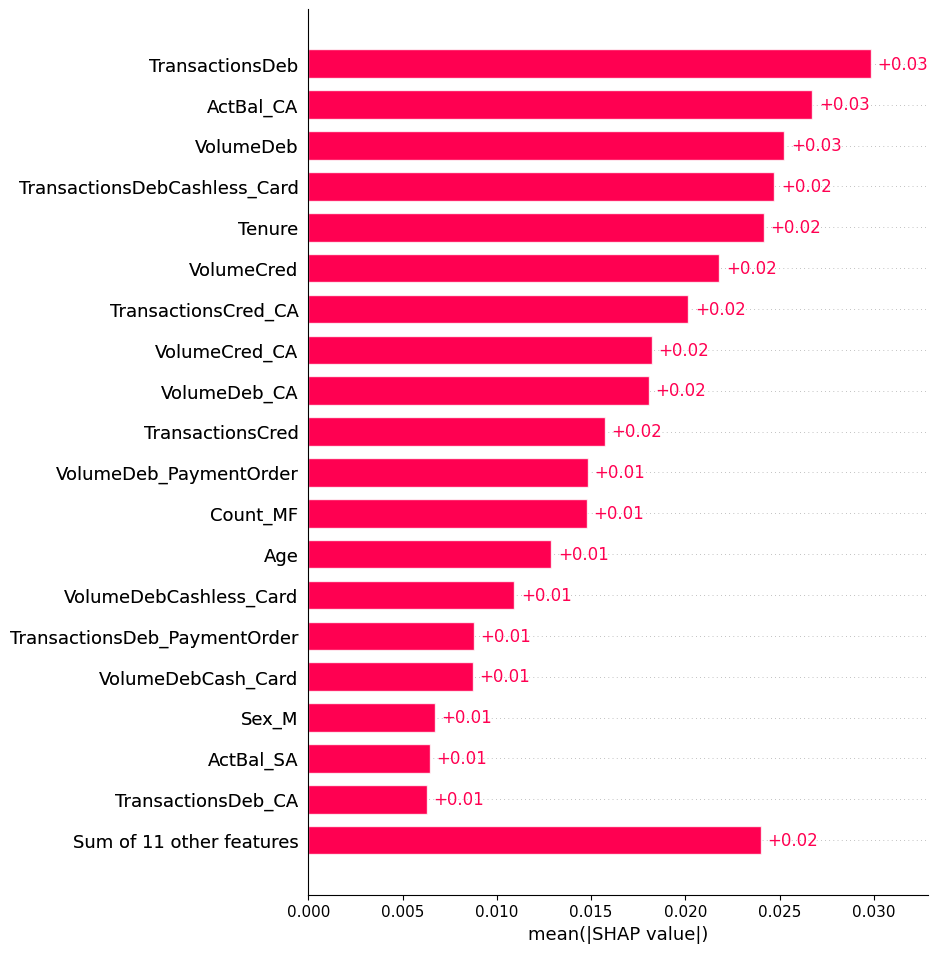

In [40]:
# Shapley importances
shap.plots.bar(shap_values=shap_values[...,1], max_display=20)

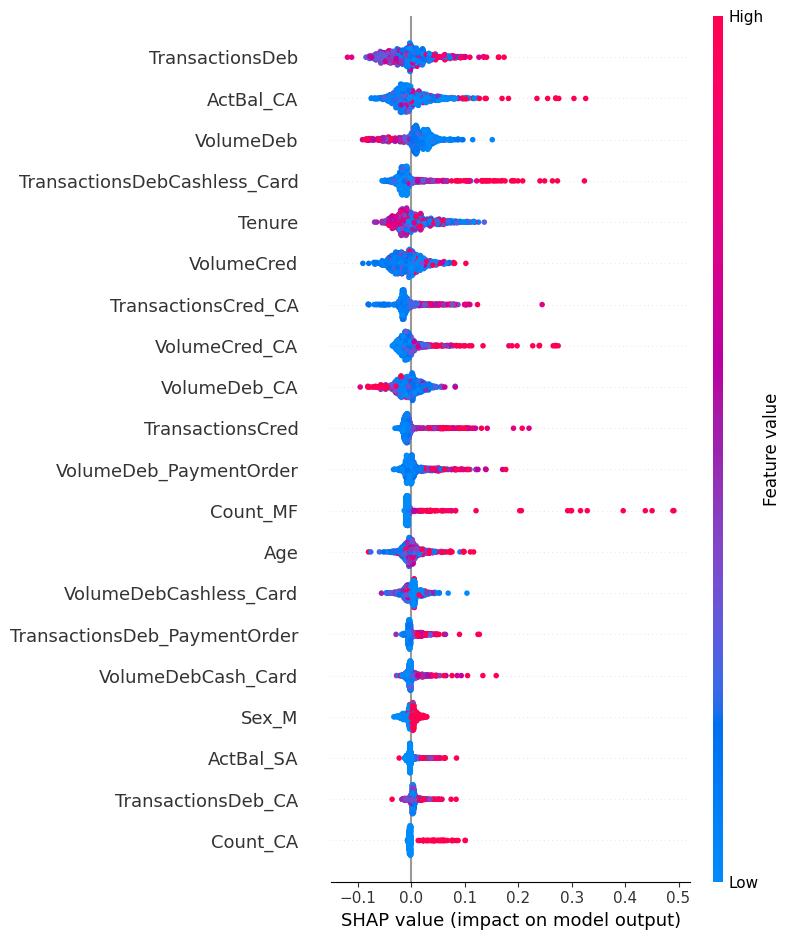

In [41]:
# Shapley beeswarm
shap.summary_plot(shap_values[...,1], features=X_train_prep, feature_names=names_after)

### CC

In [42]:
# Extract best hyperparameters
best_params_CC = study_CC.best_params

best_max_features = best_params_CC["max_features"]
best_n_estimators = best_params_CC["n_estimators"]
best_min_samples_split = best_params_CC["min_samples_split"]
best_max_depth = best_params_CC["max_depth"]
best_min_samples_leaf = best_params_CC["min_samples_leaf"]

print(best_params_CC)

{'max_features': 20, 'min_samples_split': 0.17397539938331852, 'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 13}


In [43]:
# Train HistGradientBoostingClassifier 
Classifier = sklearn.ensemble.RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    min_samples_split = best_min_samples_split,
    max_features=best_max_features,
    random_state=42
)
pipeline = make_pipeline(Preprocessor, Classifier)
pipeline.fit(X_train, CC_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28]),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [0])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=7, max_features=20,
                                        min_samples_leaf=3,
                                        min_samples_split=0.17397539938331852,
                                        n_estimators=13, random_state=42))])

In [44]:
CC_pred_RF_test = pipeline.predict(X=X_test)
# Predictions training set
sklearn.metrics.balanced_accuracy_score(y_pred=CC_pred_RF_test, y_true=CC_test)

0.5370865587614356

This score is worse than logistic regression -> go further with logistic regression

In [45]:
final_pipeline_CC = pipeline_LR.fit(X_train, CC_train)
# Predictions test set
CC_pred_LR_train = final_pipeline_CC.predict(X=X_train)
CC_pred_LR_test = final_pipeline_CC.predict(X=X_test)
coefficients = final_pipeline_CC.named_steps['logisticregression'].coef_

In [46]:
def plot_LR_coef(coefficients: np.ndarray, feature_names: list[str]):
    # Filter out the non-zero coefficients
    non_zero_mask = coefficients != 0
    non_zero_coefficients = coefficients[non_zero_mask]
    non_zero_features = np.array([feature_names])[non_zero_mask]

    # Sort the coefficients by absolute value
    sorted_indices = np.argsort(np.abs(non_zero_coefficients,))
    sorted_non_zero_coefficients = non_zero_coefficients[sorted_indices]
    sorted_non_zero_features = non_zero_features[sorted_indices]

    # Plot the sorted non-zero coefficients
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_non_zero_features, sorted_non_zero_coefficients)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Non-zero Coefficients of Linear Regression Model (Sorted by Size)')
    plt.show()

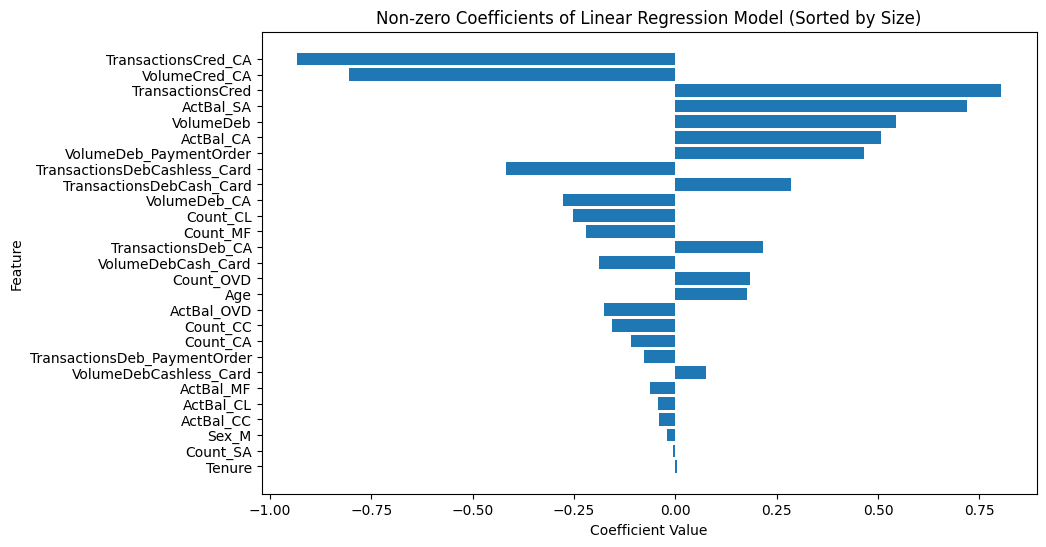

In [47]:
plot_LR_coef(coefficients=coefficients, feature_names=names_after)

In [92]:
# Generate Shapley values
explainer = shap.LinearExplainer(final_pipeline_CC.named_steps["logisticregression"], masker=shap.maskers.Impute(data=X_train_prep))
shap_values = explainer(X_train_prep)

Estimating transforms: 100%|██████████| 1000/1000 [00:02<00:00, 420.00it/s]


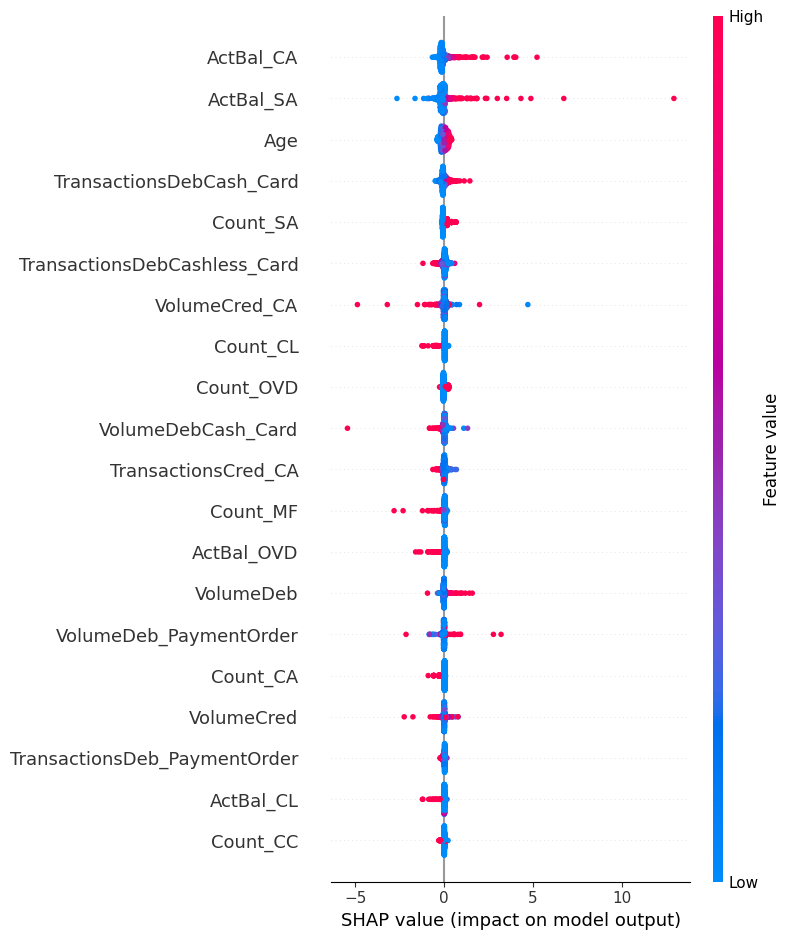

In [93]:
# Shapley beeswarm
shap.summary_plot(shap_values, features=X_train_prep, feature_names=names_after)

### CL

In [98]:
# Extract best hyperparameters
best_params_CL = study_CL.best_params

best_max_features = best_params_CL["max_features"]
best_n_estimators = best_params_CL["n_estimators"]
best_min_samples_split = best_params_CL["min_samples_split"]
best_max_depth = best_params_CL["max_depth"]
best_min_samples_leaf = best_params_CL["min_samples_leaf"]

print(best_params_CL)

{'max_features': 29, 'min_samples_split': 0.06991440728186084, 'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 52}


In [99]:
# Train HistGradientBoostingClassifier 
Classifier = sklearn.ensemble.RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    min_samples_split = best_min_samples_split,
    max_features=best_max_features,
    random_state=42
)
final_pipeline_CL = make_pipeline(Preprocessor, Classifier)
final_pipeline_CL.fit(X_train, CL_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28]),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [0])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=16, max_features=29,
                                        min_samples_split=0.06991440728186084,
                                        n_estimators=52, random_state=42))])

In [100]:
# Predictions training and test set
CL_pred_LR_train = final_pipeline_CL.predict(X=X_train)
CL_pred_LR_test = final_pipeline_CL.predict(X_test)
sklearn.metrics.balanced_accuracy_score(y_pred=CL_pred_LR_test, y_true=CL_test)

0.6046296296296296

This score is worse than logistic regression -> go further with logistic regression

In [101]:
final_pipeline_CL = pipeline_LR.fit(X_train, CL_train)
# Predictions test set
CL_pred_LR_train = final_pipeline_CL.predict(X=X_train)
CL_pred_LR_test = final_pipeline_CL.predict(X=X_test)
coefficients = final_pipeline_CL.named_steps['logisticregression'].coef_

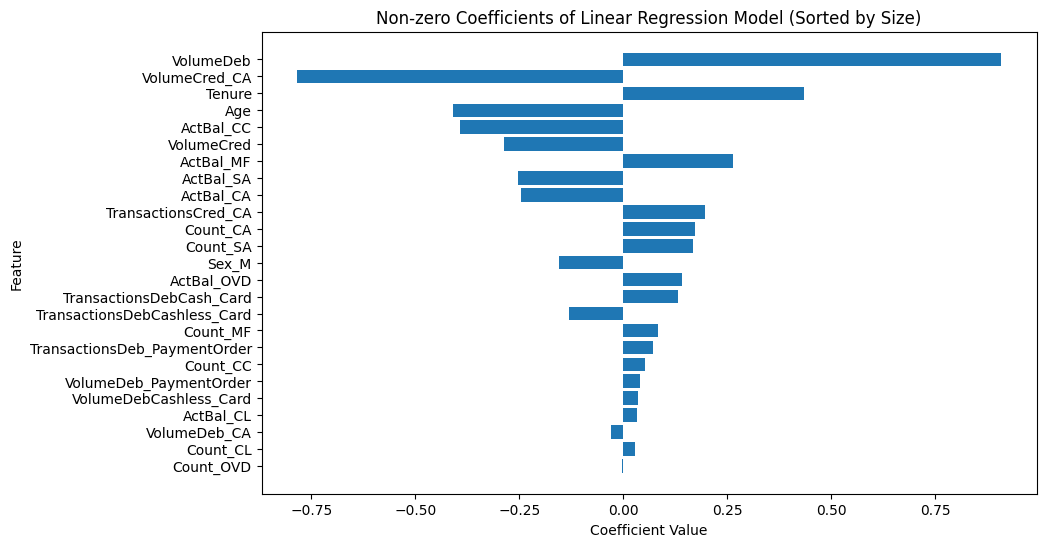

In [102]:
plot_LR_coef(coefficients=coefficients, feature_names=names_after)

Caution when interpreting, first 2 variables are highly correlated so coefficients are inflated.

In [103]:
# Generate Shapley values
explainer = shap.LinearExplainer(final_pipeline_CL.named_steps["logisticregression"], masker=shap.maskers.Impute(data=X_train_prep))
shap_values = explainer(X_train_prep)

Estimating transforms: 100%|██████████| 1000/1000 [00:02<00:00, 472.20it/s]


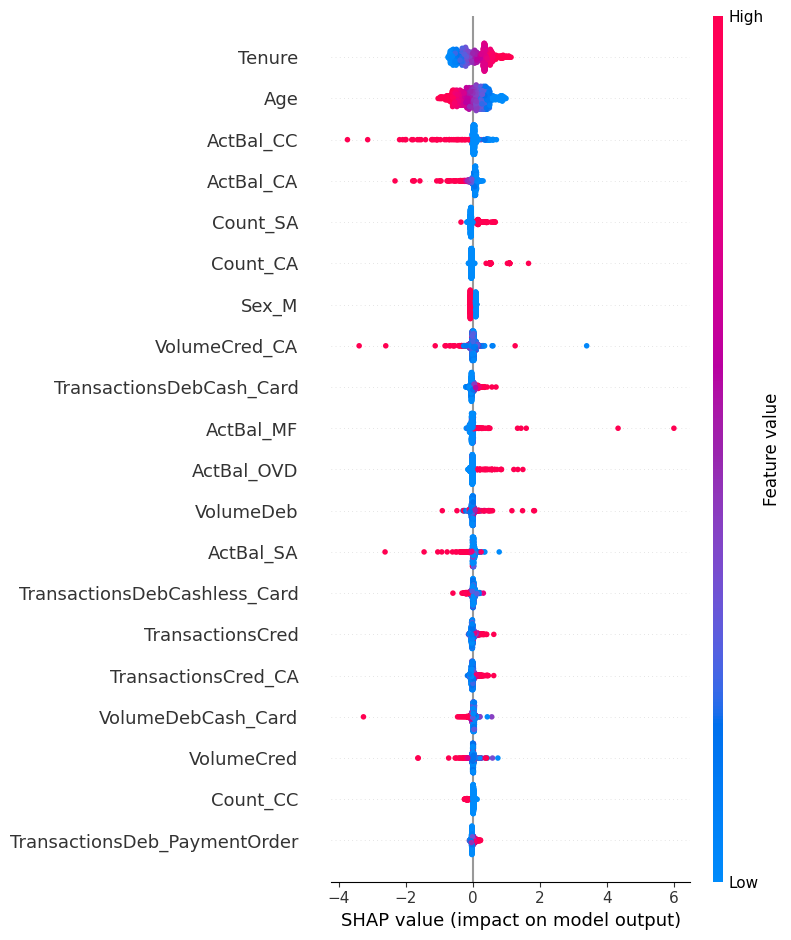

In [104]:
# Shapley beeswarm
shap.summary_plot(shap_values, features=X_train_prep, feature_names=names_after)

## Revenue models

These models include the "Sale" variable to predict the expected revenue per customer

In [105]:
# Select columns
MF_basetable = basetable[basetable.Sale_MF==1].drop(["Sale_MF", "Sale_CC", "Sale_CL"], axis=1).drop(["Revenue_CC", "Revenue_CL"], axis=1)
CC_basetable = basetable[basetable.Sale_CC==1].drop(["Sale_MF", "Sale_CC", "Sale_CL"], axis=1).drop(["Revenue_MF", "Revenue_CL"], axis=1)
CL_basetable = basetable[basetable.Sale_CL==1].drop(["Sale_MF", "Sale_CC", "Sale_CL"], axis=1).drop(["Revenue_CC", "Revenue_MF"], axis=1)

In [106]:
# Seperate independent and dependent var and imputate missing
X_MF = MF_basetable.iloc[:,1:30].fillna(value=0)
X_CC = CC_basetable.iloc[:,1:30].fillna(value=0)
X_CL = CL_basetable.iloc[:,1:30].fillna(value=0)
MF_rev = MF_basetable.Revenue_MF
CC_rev = CC_basetable.Revenue_CC
CL_rev = CL_basetable.Revenue_CL

In [107]:
# Train-test split
X_MF_train, X_MF_test, MF_training_revenue, MF_testing_revenue = train_test_split(X_MF, MF_rev, test_size=0.2, random_state=42)
X_CC_train, X_CC_test, CC_training_revenue, CC_testing_revenue = train_test_split(X_CC, CC_rev, test_size=0.2, random_state=42)
X_CL_train, X_CL_test, CL_training_revenue, CL_testing_revenue = train_test_split(X_CL, CL_rev, test_size=0.2, random_state=42)


In [108]:
# Preprocessing pipeline
numeric_features = [*range(1,29)]
categorical_features = [0]
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder(drop='first'))
Preprocessor = ColumnTransformer(transformers=[("numeric_transformer", numeric_transformer, numeric_features), ("categorical_transformer", categorical_transformer, categorical_features)])

In [109]:
# Preprocess and extract feature names
X_MF_trainprep = Preprocessor.fit(X_MF_train).transform(X_MF_train)
names_after = Preprocessor.get_feature_names_out()
names_after = np.array([s.split("__")[1] for s in names_after])

In [110]:
# Lasso regression using 5-fold CV on 1000 penalty values
Classifier = sklearn.linear_model.LassoCV(n_alphas=1000)
pipeline_LR_revenue = make_pipeline(Preprocessor, Classifier)

In [112]:
pipeline_LR_revenue.fit(X_MF_train, MF_training_revenue)
coefficients_MF = pipeline_LR_revenue.named_steps['lassocv'].coef_
# Predictions training set
MF_pred_LR = pipeline_LR.predict(X=X_MF_test)
print("MF test MAPE: ", sklearn.metrics.mean_absolute_percentage_error(y_pred=MF_pred_LR, y_true=MF_testing_revenue))

pipeline_LR_revenue.fit(X_CC_train, CC_training_revenue)
coefficients_CC = pipeline_LR_revenue.named_steps['lassocv'].coef_
# Predictions training set
CC_pred_LR = pipeline_LR.predict(X=X_CC_test)
print("CC test MAPE: ", sklearn.metrics.mean_absolute_percentage_error(y_pred=CC_pred_LR, y_true=CC_testing_revenue))

pipeline_LR_revenue.fit(X_CL_train, CL_training_revenue)
coefficients_CL = pipeline_LR_revenue.named_steps['lassocv'].coef_
# Predictions training set
CL_pred_LR = pipeline_LR.predict(X=X_CL_test)
print("CL test MAPE: ", sklearn.metrics.mean_absolute_percentage_error(y_pred=CL_pred_LR, y_true=CL_testing_revenue))

MF test MAPE:  0.9763858660163311
CC test MAPE:  1.2358760651266874
CL test MAPE:  0.9500285605889257


In [113]:
coefficients_MF

array([ 0.,  0., -0., -0., -0.,  0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0.,  0.])

In [114]:
coefficients_CC

array([ 0., -0., -0., -0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,
       -0.,  0., -0.])

In [115]:
coefficients_CL

array([-0.,  0., -0.,  0., -0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
       -0.,  0., -0., -0., -0.,  0.,  0.,  0., -0.,  0., -0., -0., -0.,
       -0., -0., -0.])

The linear models result in just the intercept so we can take the mean

In [116]:
# Sale and revenue target variables are joined
MF_targets = pd.DataFrame(zip(MF_train, MF_train_rev), columns=["Sale_MF", "Revenue_MF"])
CC_targets = pd.DataFrame(zip(CC_train, CC_train_rev), columns=["Sale_CC", "Revenue_CC"])
CL_targets = pd.DataFrame(zip(CL_train, CL_train_rev), columns=["Sale_CL", "Revenue_CL"])

# Calculate expected revenue
expected_revenue_MF = (MF_targets[MF_targets["Sale_MF"]==1]["Revenue_MF"]).mean()
expected_revenue_CC = (CC_targets[CC_targets["Sale_CC"]==1]["Revenue_CC"]).mean()
expected_revenue_CL = (CL_targets[CL_targets["Sale_CL"]!=0]["Revenue_CL"]).mean()

In [117]:
print("expected revenue MF:", expected_revenue_MF)
print("expected revenue CC:", expected_revenue_CC)
print("expected revenue CL:", expected_revenue_CL)

expected revenue MF: 10.00951213818861
expected revenue CC: 9.911730199851961
expected revenue CL: 12.219524818401936


### Revenue calculation on test set

In [118]:
# Final fit and predict propensity
final_pipeline_MF.fit(X_train, MF_train)
MF_sales_preds_test = final_pipeline_MF.predict_proba(X_test)[:,1]

final_pipeline_CC.fit(X_train, CC_train)
CC_sales_preds_test = final_pipeline_CC.predict_proba(X_test)[:,1]

final_pipeline_CL.fit(X_train, CL_train)
CL_sales_preds_test = final_pipeline_CL.predict_proba(X_test)[:,1]

In [119]:
# Calculate expected revenues, taking in account propensity
c_v_MF = MF_sales_preds_test*expected_revenue_MF
c_v_CC = CC_sales_preds_test*expected_revenue_CC
c_v_CL = CL_sales_preds_test*expected_revenue_CL
expected_revenues_table = pd.DataFrame(zip(X_test.index, c_v_MF, c_v_CC, c_v_CL, MF_test_rev, CC_test_rev, CL_test_rev), columns=['Client_ID', 'Exp_Value_MF', 'Exp_Value_CC', 'Exp_Value_CL', 'Real_Value_MF', 'Real_Value_CC', 'Real_Value_CL'])

Now 15% of the data is selected based on the maximum value over the expected values columns, in order to maximally increase revenue.

In [121]:
# Step 1: Compute the maximum value across the three columns for each row
expected_revenues_table['Max_Value'] = expected_revenues_table[['Exp_Value_MF', 'Exp_Value_CC', 'Exp_Value_CL']].max(axis=1)

# Step 2: Sort the DataFrame based on these maximum values in descending order
expected_revenues_table_sorted = expected_revenues_table.sort_values(by='Max_Value', ascending=False)

# Step 3: Select the top 15% of the rows
top_15_percent_rows = expected_revenues_table_sorted.head(int(len(expected_revenues_table) * 0.15))

In [122]:
total_model_revenue = top_15_percent_rows[["Real_Value_MF", "Real_Value_CC", "Real_Value_CL"]].sum().sum()
print(total_model_revenue)

353.5551785714286


This is compared with selecting 15% at random

In [ ]:
# Function to sample 15% of the rows and compute max values
def sample_and_compute_revenue(df):
    sample = df.sample(frac=0.15)
    return sample[["Real_Value_MF", "Real_Value_CC", "Real_Value_CL"]].sum().sum()

In [131]:
# Perform the sampling and computation 100 times
samples = [sample_and_compute_revenue(expected_revenues_table) for _ in range(100)]

In [132]:
total_random_revenue = np.mean(samples)
print("Revenue increase due to model =", total_model_revenue - total_random_revenue)

Revenue increase due to model = 132.70827857142862


This difference is equal to ~4 per targeted client (29 targetted clients)

# Deployment

In [133]:
# Select needed columns
deployment_data = basetable[basetable.Sale_MF.isna()].drop(['Sale_MF', 'Sale_CC', 'Sale_CL',
'Revenue_MF', 'Revenue_CC', 'Revenue_CL'], axis=1)

In [134]:
# Impute missing values
final_X = X_sales.fillna(value=0)
deployment_data = deployment_data.fillna(value=0)

In [135]:
# Final fit and predict propensity
final_pipeline_MF.fit(final_X, MF_sales)
MF_sales_preds = final_pipeline_MF.predict_proba(deployment_data)[:,1]

final_pipeline_CC.fit(final_X, CC_sales)
CC_sales_preds = final_pipeline_CC.predict_proba(deployment_data)[:,1]

final_pipeline_CL.fit(final_X, CL_sales)
CL_sales_preds = final_pipeline_CL.predict_proba(deployment_data)[:,1]

In [136]:
# Calculate expected revenues
expected_revenue_MF = (basetable[basetable["Sale_MF"]==1]["Revenue_MF"]).mean()
expected_revenue_CC = (basetable[basetable["Sale_CC"]==1]["Revenue_CC"]).mean()
expected_revenue_CL = (basetable[basetable["Sale_CL"]==1]["Revenue_CL"]).mean()

In [148]:
print(expected_revenue_MF)
print(expected_revenue_CC)
print(expected_revenue_CL)

9.664974093264249
10.862516233766234
12.043066502463054


In [137]:
# Calculate expected revenues, taking in account propensity
c_v_MF = MF_sales_preds*expected_revenue_MF
c_v_CC = CC_sales_preds*expected_revenue_CC
c_v_CL = CL_sales_preds*expected_revenue_CL
expected_revenues_table = pd.DataFrame(zip(test.index, c_v_MF, c_v_CC, c_v_CL), columns=['Client_ID', 'Exp_Value_MF', 'Exp_Value_CC', 'Exp_Value_CL'])

In [139]:
# Step 1: Compute the maximum value across the three columns for each row
expected_revenues_table['Max_Value'] = expected_revenues_table[['Exp_Value_MF', 'Exp_Value_CC', 'Exp_Value_CL']].max(axis=1)

# Step 2: Sort the DataFrame based on these maximum values in descending order
expected_revenues_table_sorted = expected_revenues_table.sort_values(by='Max_Value', ascending=False)

# Step 3: Select the top 15% of the rows
top_15_percent_rows = expected_revenues_table_sorted.head(int(len(expected_revenues_table) * 0.15))

In [140]:
total_model_revenue = top_15_percent_rows[["Exp_Value_MF", "Exp_Value_CC", "Exp_Value_CL"]].sum().sum()
print(total_model_revenue)

1227.460322858472


The marketing campaign returns an expected revenue of 1,227. 

In [141]:
# Select column
top_15_percent_rows['Exp_Value_MF'] = (top_15_percent_rows['Exp_Value_MF'] == top_15_percent_rows['Max_Value'])
top_15_percent_rows['Exp_Value_CC'] = (top_15_percent_rows['Exp_Value_CC'] == top_15_percent_rows['Max_Value'])
top_15_percent_rows['Exp_Value_CL'] = (top_15_percent_rows['Exp_Value_CL'] == top_15_percent_rows['Max_Value'])


C:\Users\simon\AppData\Local\Temp\ipykernel_42900\3870813352.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\simon\AppData\Local\Temp\ipykernel_42900\3870813352.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\simon\AppData\Local\Temp\ipykernel_42900\3870813352.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [142]:
top_15_percent_rows

,Client_ID,Exp_Value_MF,Exp_Value_CC,Exp_Value_CL,Max_Value
430,1076,False,False,True,12.042952
518,1288,False,False,True,12.039500
582,1454,False,False,True,12.013544
131,313,False,False,True,11.417365
549,1372,False,False,True,11.400946
...,...,...,...,...,...
335,827,False,False,True,6.110584
58,144,False,True,False,6.077718
217,521,False,False,True,6.056249
203,484,False,False,True,6.029349


In [143]:
# Extract lists
MF_targets_list = top_15_percent_rows[top_15_percent_rows.Exp_Value_MF==True]
CC_targets_list = top_15_percent_rows[top_15_percent_rows.Exp_Value_CC==True]
CL_targets_list = top_15_percent_rows[top_15_percent_rows.Exp_Value_CL==True]

In [144]:
# Save lists
MF_targets_list[["Client_ID", "Max_Value"]].to_csv("./target_lists/MF_targets_list.csv")
CC_targets_list[["Client_ID", "Max_Value"]].to_csv("./target_lists/CC_targets_list.csv")
CL_targets_list[["Client_ID", "Max_Value"]].to_csv("./target_lists/CL_targets_list.csv")